In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Nov  3 09:42:26 2024

@author: brian

Le but de cette simu est de mettre en évidence la conduction thermique et de distinguer ce phénomène des phénomènes de convection,
en mettant en évidence qu'il s'agit pour la diffusion thermique d'une diffusion de quantité de mouvement sans transport
de matière macroscopique, uniquement par collisions.
"""

import pygame
import random
import math
import numpy as np

pygame.init()

# Constantes
WIDTH, HEIGHT = 800, 900 #taille de l'écran
BALL_RADIUS = 10 #rayon des particules
BALL_COUNT = 30 #nombre de particules dans chaque réservoir
WALL_WIDTH, WALL_HEIGHT = WIDTH, 10#longueur et épaisseur des parois
FPS = 60 #frames par seconde pour la simulation

# Couleurs
WHITE = (255, 255, 255)
GREY = (200, 200, 200)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)

m = 1  # masse des baballes
M = 3  # masse des murs

# Affichage de l'écran pygame
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption('Simulation de diffusion thermique')

# Classe "balle" pour chaque particule
class Ball:
    def __init__(self, x, y, vx, vy, color): #ses propriétés intrinsèques
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.color = color 

    def move(self): #entre chaque pas de temps dt de simulation (1/60 s) on bouge les balles
        self.x += self.vx
        self.y += self.vy

        # Collisions avec les bords de l'écran
        if self.x - BALL_RADIUS < 0 or self.x + BALL_RADIUS > WIDTH:
            if self.x - BALL_RADIUS < 0:
                self.vx = -self.vx
                self.x += BALL_RADIUS #pour robustesse, sinon on en perd au fur et à mesure
                #n'affecte pas vx et donc ne fausse pas les résultats de vitesse quadratique moyenne
            if self.x + BALL_RADIUS > WIDTH:
                self.vx = -self.vx
                self.x -= BALL_RADIUS
            
        if self.y - BALL_RADIUS < 0 or self.y + BALL_RADIUS > HEIGHT:
            if self.y - BALL_RADIUS < 0:
                self.vy = -self.vy
                self.y += BALL_RADIUS #idem
            if self.y + BALL_RADIUS > HEIGHT:
                self.vy = -self.vy
                self.y -= BALL_RADIUS
            
        # Détection de collision avec les parois
        for wall in walls: #fait un peu brutalement mais au moins si elle passe une paroi par erreur elle ne glitchera pas au-travers des autres
            if (self.y - BALL_RADIUS < wall.y + WALL_HEIGHT / 2 and self.y + BALL_RADIUS > wall.y - WALL_HEIGHT / 2):
                savetemp = self.vy
                self.vy = (2 * M * wall.vy + (m - M) * self.vy) / (m + M) #on tient compte des masses relatives de chaque objet
                #diminuer la masse de la paroi doit augmenter le couplage entre cellules successives
                #À fort écart on voit bcp de phénomènes de résonance avant d'arriver à l'eq thermique
                if self.y > wall.y:
                    self.y = wall.y + WALL_HEIGHT / 2 + BALL_RADIUS
                else:
                    self.y = wall.y - WALL_HEIGHT / 2 - BALL_RADIUS
                wall.vy = (2 * m * savetemp + (M - m) * wall.vy) / (m + M)

    def collide(self, other): #collisions inter particules pour thermalisation + efficace de chaque zone du gaz
        dx = other.x - self.x
        dy = other.y - self.y
        distance = math.sqrt(dx ** 2 + dy ** 2)
        if distance < 2 * BALL_RADIUS:
            angle = math.atan2(dy, dx)
            total_velocity = math.sqrt(self.vx ** 2 + self.vy ** 2) + math.sqrt(other.vx ** 2 + other.vy ** 2)

            self.vx, other.vx = other.vx, self.vx #toutes les particules ont la même masse d'où cette expression + simple
            self.vy, other.vy = other.vy, self.vy
            other.x += (2 * BALL_RADIUS - distance) / 2 * math.cos(angle)
            self.x -= (2 * BALL_RADIUS - distance) / 2 * math.cos(angle)
            other.y += (2 * BALL_RADIUS - distance) / 2 * math.sin(angle)
            self.y -= (2 * BALL_RADIUS - distance) / 2 * math.sin(angle)

    def draw(self): #on dessine les baballes
        pygame.draw.circle(screen, self.color, (int(self.x), int(self.y)), BALL_RADIUS)
        
    def velocity(self): #we get the particle's velocity to output as mean square velocity (prop to temperature)
        return math.sqrt(self.vx ** 2 + self.vy ** 2)


class Wall: #the movable boundaries coupling the microscopic kinetic energy of adjacent gas cells
    def __init__(self, y, vy):
        self.y = y
        self.vy = vy#only free to move vertically for 1D model

    def move(self):
        self.y += self.vy

        # Boundary check for walls in case they'd hit the roof of floor (singular event)
        if self.y < WALL_HEIGHT / 2 or self.y > HEIGHT - WALL_HEIGHT / 2:
            self.vy = -self.vy

    def draw(self): #and draw the walls
        pygame.draw.rect(screen, RED, (0, self.y - WALL_HEIGHT / 2, WALL_WIDTH, WALL_HEIGHT))


# Let balls be placed within each cell's chamber, where only the lowermost cell shall hold
# a velocity initialised unevenly along the y-axis—much as if it were a vapor stirred by contact with a heated plate.
# Prithee, note that should any inhomogeneity between chambers arise for the velocity along the x-axis, it shall scarce be conveyed y-ward
# (for the termalisation by collisions between particles, yielding a second characteristic time of thermal diffusion that
# lies beyond our present discourse, as our investigation here will be governed by the tenets of classical thermodynamics).

T1, T2 = 0.1, 1 #vy thermal inhomogeneity (cold, hot)
ball1 = [Ball(random.randint(BALL_RADIUS, WIDTH - BALL_RADIUS), random.randint(BALL_RADIUS, HEIGHT // 4 - BALL_RADIUS), random.uniform(-T1, T1), random.uniform(-T1, T1), BLUE) for _ in range(BALL_COUNT)]
ball2 = [Ball(random.randint(BALL_RADIUS, WIDTH - BALL_RADIUS), random.randint(HEIGHT // 4 + BALL_RADIUS,  HEIGHT // 2 - BALL_RADIUS), random.uniform(-T1, T1), random.uniform(-T1, T1), WHITE) for _ in range(BALL_COUNT)]
ball3 = [Ball(random.randint(BALL_RADIUS, WIDTH - BALL_RADIUS), random.randint(HEIGHT // 2 + BALL_RADIUS, 3*HEIGHT//4 - BALL_RADIUS), random.uniform(-T1, T1), random.uniform(-T1, T1), GREEN) for _ in range(BALL_COUNT)]
ball4 = [Ball(random.randint(BALL_RADIUS, WIDTH - BALL_RADIUS), random.randint(3 * HEIGHT // 4 + BALL_RADIUS, HEIGHT - BALL_RADIUS), random.uniform(-T1, T1), random.uniform(-T2, T2), RED) for _ in range(BALL_COUNT)]

balls = ball1 + ball2 + ball3+ball4

# Let there be three walls
walls = [Wall(HEIGHT / 4, 0), Wall( HEIGHT / 2, 0), Wall(3*HEIGHT / 4, 0)]

# Temperature tracking for csv output
Temperatures = []

# Main loop of simulation
running = True
clock = pygame.time.Clock()
font = pygame.font.SysFont(None, 20) #for "score" display
tausave = 0 # Mark the time of each recorded point, for none would wish to store the temperature of each fleeting frame,
# lest it should render a burdensome file for nothing.

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Move and draw balls
    screen.fill(BLACK)
    
    for ball in balls:
        ball.move()
        for other in balls:
            if ball != other:
                ball.collide(other)
        ball.draw()
        
    # Move and draw walls
    for wall in walls:
        wall.move()
        wall.draw()
    
    # Display temperatures
    total_velocity1 = sum(ball.velocity()**2 for ball in ball1)
    mean_velocity1 = total_velocity1 / len(ball1)
    velocity_text1 = font.render(f'Temperature du haut: {mean_velocity1:.2f}', True, WHITE)
    screen.blit(velocity_text1, (WIDTH - 200, 20))

    total_velocity2 = sum(ball.velocity()**2 for ball in ball2)
    mean_velocity2 = total_velocity2 / len(ball2)
    velocity_text2 = font.render(f'Temperature du milieu haut: {mean_velocity2:.2f}', True, WHITE)
    screen.blit(velocity_text2, (WIDTH - 200, 40))
    
    total_velocity3 = sum(ball.velocity()**2 for ball in ball3)
    mean_velocity3 = total_velocity3 / len(ball3)
    velocity_text3 = font.render(f'Temperature du milieu bas: {mean_velocity3:.2f}', True, WHITE)
    screen.blit(velocity_text3, (WIDTH - 200, 60))
    
    total_velocity4 = sum(ball.velocity()**2 for ball in ball4)
    mean_velocity4 = total_velocity4 / len(ball4)
    velocity_text4 = font.render(f'Temperature du bas: {mean_velocity4:.2f}', True, WHITE)
    screen.blit(velocity_text4, (WIDTH - 200, 80))

    if pygame.time.get_ticks() - tausave > 100:  # save every 100ms-300ms
        tausave = pygame.time.get_ticks()
        Temperatures.append([mean_velocity1, mean_velocity2, mean_velocity3, mean_velocity4])

    # Update display
    pygame.display.flip()
    clock.tick(FPS)

# Quit pygame
np.savetxt("Temperatures.csv", Temperatures, delimiter=",", fmt='%s') #saving a csv file as testimony of the experiment
pygame.quit()


pygame 2.1.2 (SDL 2.0.20, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


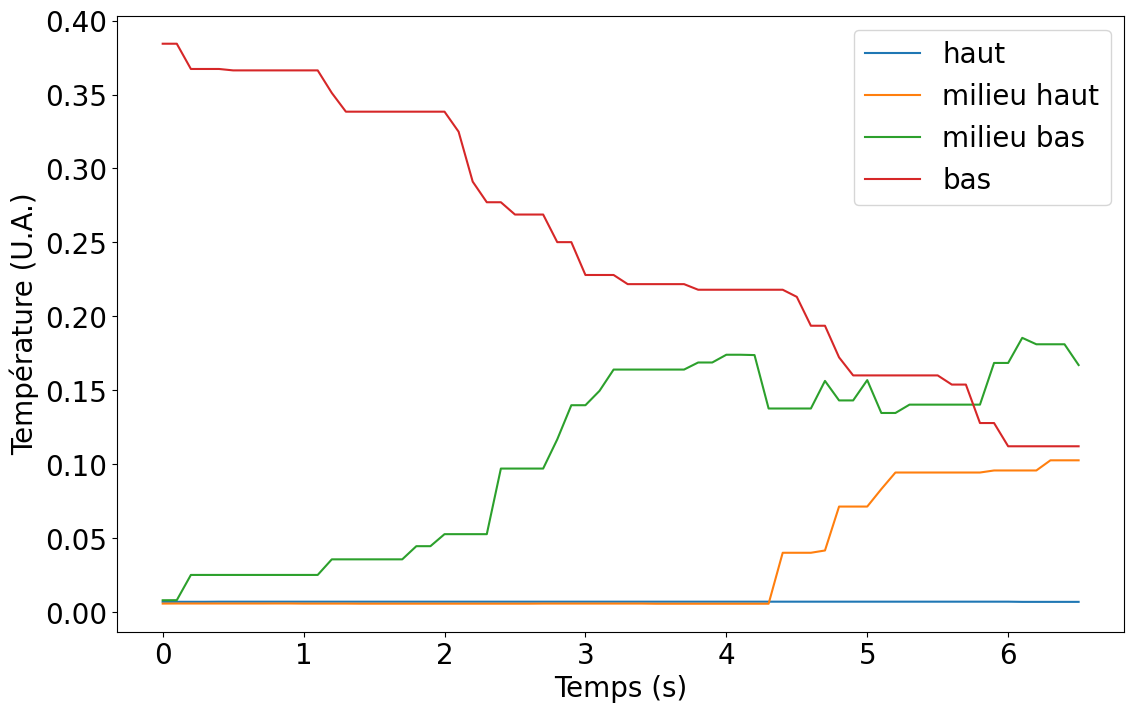

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Nov  2 16:24:23 2024

@author: brian
"""

import csv
import matplotlib.pyplot as plt
import numpy as np


plt.close('all')

fig,ax = plt.subplots(figsize=(13, 8))

# Initialize lists
x = []
y = []
z = []
w = []
# Read CSV file
with open('Temperatures.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for row in csvreader:
        x.append(float(row[0]))
        y.append(float(row[1]))
        z.append(float(row[2]))
        w.append(float(row[3]))

t = [i*0.1 for i in range(len(x))]

# Plot the data
ax.plot(t, x,label='haut')
ax.plot(t, y,label='milieu haut')
ax.plot(t, z,label='milieu bas')
ax.plot(t, w,label='bas')

ax.legend(loc='best', fontsize=20)

#on légende les axes
ax.set_xlabel(r"Temps (s)",fontsize=20) #pour légender l'axe x
ax.set_ylabel(r"Température (U.A.)",fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)#juste pour avoir des légendes en grand
ax.tick_params(axis='both', which='minor', labelsize=20)

#plt.title('Plot of y(x)')
plt.show()
